In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

In [3]:
import HTSeq
import pysam

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

------------------------------

## Config

In [6]:
import sys

In [7]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

In [8]:
# needed to import all our code
my_scripts_dir = os.path.join(project_dir, 'htseq/scripts')
if my_scripts_dir not in sys.path:
    sys.path.append(my_scripts_dir)

In [9]:
import coverage as cov

In [10]:
import estimate_input_factor as ip

- other **directories**

In [11]:
data_dir

'/gcm-lfs1/pablo/data/rna_silencing/seq_data'

In [12]:
results_dir = data_results_dir
results_dir

'/gcm-lfs1/pablo/data/rna_silencing/results'

------

# INPUT Normalization: **Protein coding regions** (mRNA)

------------

## Workflow

- Load `sample` and corresponding `INPUT` BAM files.
- Create coverage for region of interest: 
    - **SPAC23G3.02c (sib1)**: `I - 854453 - 869704`
    - **SPCC737.08 (mdn1)**: `III - 1900472 - 1914833`
    - **SPAC1093.06c (dhc1)**: `I - 4622166 - 4635111`
- Using [`fragment_size`](https://htseq.readthedocs.io/en/master/tss.html#using-the-full-coverage) `= None`

--------------------------

### Define Parameters

In [13]:
ip_type = 'S2'
#ip_type = 'S5'

- Define `ChIP` sample and corresponding `INPUT`

In [14]:
mutant_id = "638" # ago1
#mutant_id = "WT" # ago1

In [15]:
replicate_chip = "1"
replicate_ip = "1"
#replicate_ip = "3"

In [16]:
data_batch = 'H3K9me2'
data_input_batch = 'INPUT'

In [17]:
#dataset_id =  "WT_H3K9me2_1"
dataset_id =  mutant_id + "_" + data_batch + "_" + replicate_chip
print("Used ChIP `dataset_id`:", dataset_id)

#input_dataset_id = "WT_S2-ChIP-INPUT_1"
input_dataset_id =  mutant_id + "_" + ip_type + "-ChIP-" + data_input_batch + "_" + replicate_ip
print("Used INPUT `dataset_id`:", input_dataset_id)

Used ChIP `dataset_id`: 638_H3K9me2_1
Used INPUT `dataset_id`: 638_S2-ChIP-INPUT_1


- Load `BAM` files: instantiate BAM_Reader Object

In [18]:
bam_file = os.path.join(data_dir, data_batch, "bam", dataset_id, dataset_id + ".Aligned.sortedByCoord.out.bam")
print(bam_file)
#bam = HTSeq.BAM_Reader(bam_file)

/gcm-lfs1/pablo/data/rna_silencing/seq_data/H3K9me2/bam/638_H3K9me2_1/638_H3K9me2_1.Aligned.sortedByCoord.out.bam


In [19]:
input_bam_file =  os.path.join(data_dir, data_input_batch, "bam", input_dataset_id, input_dataset_id +  ".Aligned.sortedByCoord.out.bam")
print(input_bam_file)
#input_bam = HTSeq.BAM_Reader(input_bam_file)

/gcm-lfs1/pablo/data/rna_silencing/seq_data/INPUT/bam/638_S2-ChIP-INPUT_1/638_S2-ChIP-INPUT_1.Aligned.sortedByCoord.out.bam


- Define characteristics for **coverage interval**:

Longest **protein coding regions** (mRNA genes) which contain no heterochromatin and are therefore noise.

In [20]:
# # instead we can follow:
# # => https://htseq.readthedocs.io/en/master/tss.html#using-indexed-bam-files
# i_1 = {'chrom':'I', 'start_position': 3765776, 'end_position': 3776547}
# i_2 = {'chrom':'II', 'start_position': 1619269, 'end_position': 1629017}
# i_3 = {'chrom':'III', 'start_position': 1093002, 'end_position': 1105987}
# genomic_intervals = [i_1, i_2, i_3]

In [21]:
gdf_file = os.path.join(project_data_dir, 'annotation/gff_v2/Schizosaccharomyces_pombe_all_chromosomes.extended.features.csv')

In [22]:
# Import Gene Data Table (gdf)
gdf = pd.read_csv(gdf_file, sep='\t')
gdf.head()

,seqid,source,type,start,end,score,strand,phase,ID,Name,gene_id,gene_name,transcript_id,cds_length,utr_length,intron_length,bio_type,gene_length,transcript_length,category
0,I,PomBase,gene,1798347,1799015,.,+,.,SPAC1002.01,mrx11,SPAC1002.01,mrx11,SPAC1002.01.1,540.0,NaN,129.0,mRNA,669,540.0,gene
1,I,PomBase,gene,1799061,1800053,.,+,.,SPAC1002.02,pom34,SPAC1002.02,pom34,SPAC1002.02.1,690.0,303.0,NaN,mRNA,993,993.0,gene
2,I,PomBase,gene,1799915,1803141,.,-,.,SPAC1002.03c,gls2,SPAC1002.03c,gls2,SPAC1002.03c.1,2772.0,455.0,NaN,mRNA,3227,3227.0,gene
3,I,PomBase,gene,1803624,1804491,.,-,.,SPAC1002.04c,taf11,SPAC1002.04c,taf11,SPAC1002.04c.1,600.0,268.0,NaN,mRNA,868,868.0,gene
4,I,PomBase,gene,1804548,1806797,.,-,.,SPAC1002.05c,jmj2,SPAC1002.05c,jmj2,SPAC1002.05c.1,2148.0,102.0,NaN,mRNA,2250,2250.0,gene


In [23]:
gdf.shape

(7018, 20)

In [24]:
mrna_gdf = gdf[(gdf['bio_type'] == 'mRNA') & ~(gdf['category'] == 'repeat')].sort_values('gene_length', ascending=False)
mrna_gdf.shape

(5120, 20)

In [25]:
genomic_intervals = []
#for gg_row in mrna_gdf.head(10).itertuples():
for gg_row in mrna_gdf.itertuples():
    genomic_intervals.append({'id':gg_row.gene_id, 'chrom':gg_row.seqid, 'start':gg_row.start, 'end':gg_row.end})

In [26]:
#genomic_intervals
len(genomic_intervals)

5120

- Select `fragment_size`

In [27]:
#fragment_size = 500
#fragment_size = 200
fragment_size = None

--------------------------

## **ChIP Sample**

- Instantiate a `GenomicArray` object for the **WT sample** coverage (`cvg`)

In [28]:
cvg = cov.coverage_genomic_intervals(bam_file, genomic_intervals, count_type="frac", fragment_size=fragment_size)

Loading BAM file ...
/gcm-lfs1/pablo/data/rna_silencing/seq_data/H3K9me2/bam/638_H3K9me2_1/638_H3K9me2_1.Aligned.sortedByCoord.out.bam
Done.

Add padding: 0 

Genomic Regions:
	- I:854453-869704 (15.25 kb)
	- III:1900472-1914833 (14.36 kb)
	- I:4622166-4635111 (12.95 kb)
	- II:687626-699886 (12.26 kb)
	- I:259603-271053 (11.45 kb)
	- II:1894350-1905532 (11.18 kb)
	- II:903253-913629 (10.38 kb)
	- I:5208643-5218739 (10.10 kb)
	- II:3788890-3798775 (9.88 kb)
	- (...)


- **Visualize coverage** (`cvg`) in the genomic intervals of interest - return `cvg_profiles` as np.array()

In [29]:
cvg_profiles = {}

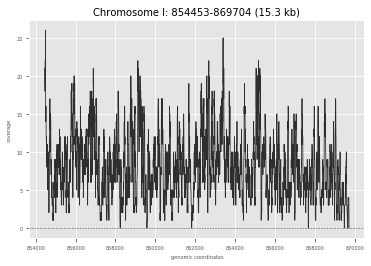

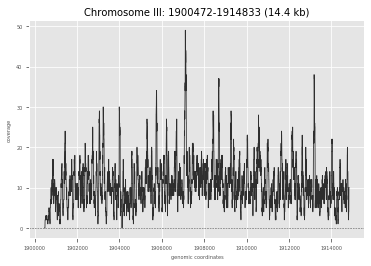

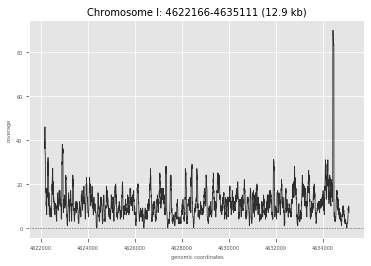

In [30]:
for ii, gg_i in enumerate(genomic_intervals):
    # only plot first regions if there are too many
    if (ii < 3):
        cvg_profiles[gg_i["id"]] = cov.plot_coverage_interval(gg_i, cvg)
    else:
        cvg_profiles[gg_i["id"]] = cov.plot_coverage_interval(gg_i, cvg, plot_coverage=False)

In [31]:
#cvg_profiles

### **INPUT Sample**

- Instantiate a `GenomicArray` object for the **INPUT sample** coverage (`input_cvg`)

In [32]:
input_cvg = cov.coverage_genomic_intervals(input_bam_file, genomic_intervals, count_type="frac", fragment_size=fragment_size)

Loading BAM file ...
/gcm-lfs1/pablo/data/rna_silencing/seq_data/INPUT/bam/638_S2-ChIP-INPUT_1/638_S2-ChIP-INPUT_1.Aligned.sortedByCoord.out.bam
Done.

Add padding: 0 

Genomic Regions:
	- I:854453-869704 (15.25 kb)
	- III:1900472-1914833 (14.36 kb)
	- I:4622166-4635111 (12.95 kb)
	- II:687626-699886 (12.26 kb)
	- I:259603-271053 (11.45 kb)
	- II:1894350-1905532 (11.18 kb)
	- II:903253-913629 (10.38 kb)
	- I:5208643-5218739 (10.10 kb)
	- II:3788890-3798775 (9.88 kb)
	- (...)


- **Visualize coverage** (`cvg`) in the genomic intervals of interest - return `input_cvg_profiles` as np.array()

In [33]:
input_cvg_profiles = {}

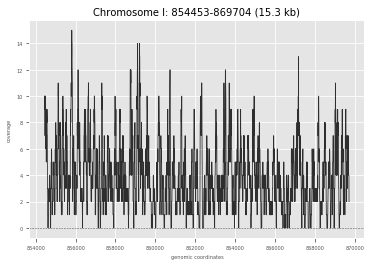

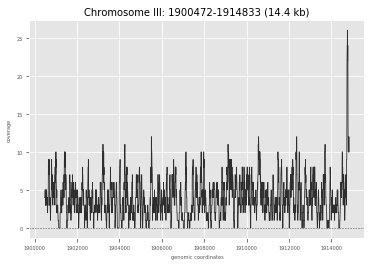

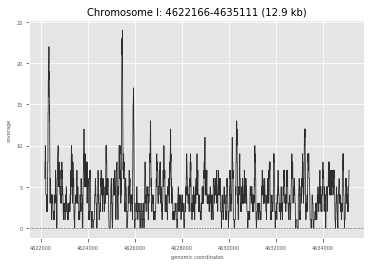

In [34]:
for ii, gg_i in enumerate(genomic_intervals):
    # only plot first regions if there are too many
    if (ii < 3):
        input_cvg_profiles[gg_i["id"]] = cov.plot_coverage_interval(gg_i, input_cvg)
    else:
        input_cvg_profiles[gg_i["id"]] = cov.plot_coverage_interval(gg_i, input_cvg, plot_coverage=False)

In [35]:
#input_cvg_profiles

------------

# Calculate **INPUT subtraction factor**

------------

## **A.** Compute Normalization Globally

- Loop over `genomic_intervals`

In [36]:
global_lambdas = {}
normed_cvg_profiles = {}

Lambda: 2.0759098560245786 

Lambda: 2.7520995171110645 

Lambda: 2.7476785142491194 



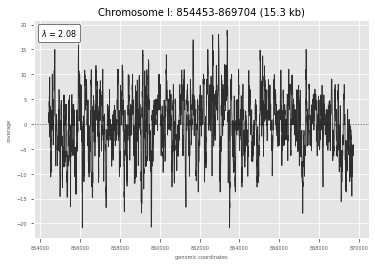

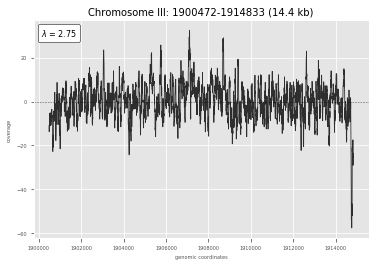

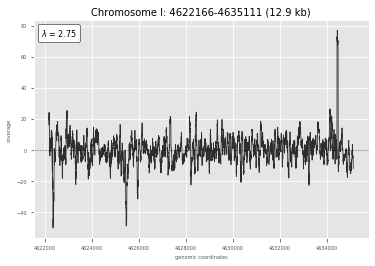

In [37]:
for ii, gg_i in enumerate(genomic_intervals):
    # only plot first regions if there are too many
    if (ii < 3):
        global_lambdas[gg_i["id"]], normed_cvg_profiles[gg_i["id"]] = ip.global_input_factor(gg_i, cvg_profiles, input_cvg_profiles)
    else:
        global_lambdas[gg_i["id"]], normed_cvg_profiles[gg_i["id"]] = ip.global_input_factor(gg_i, cvg_profiles, input_cvg_profiles, verbose=False, plot_coverage=False)

## **B.** Compute Normalization Locally: **Linear-regression**

- with `polyfit` can't fix the intercept = b = 0

In [38]:
#a, b = np.polyfit(window_input_cvg, window_cvg, 1, )

In [39]:
#b

- with `sklearn.linear_model.LinearRegression`

In [40]:
lregression_lambdas = {}
lregression_normed_cvg_profiles = {}

In [41]:
figsize = (15, 8)

Slope: 1.6151184378350263, Intercept: 0.0 

Slope: 2.0719341356995797, Intercept: 0.0 

Slope: 2.1002114363576556, Intercept: 0.0 



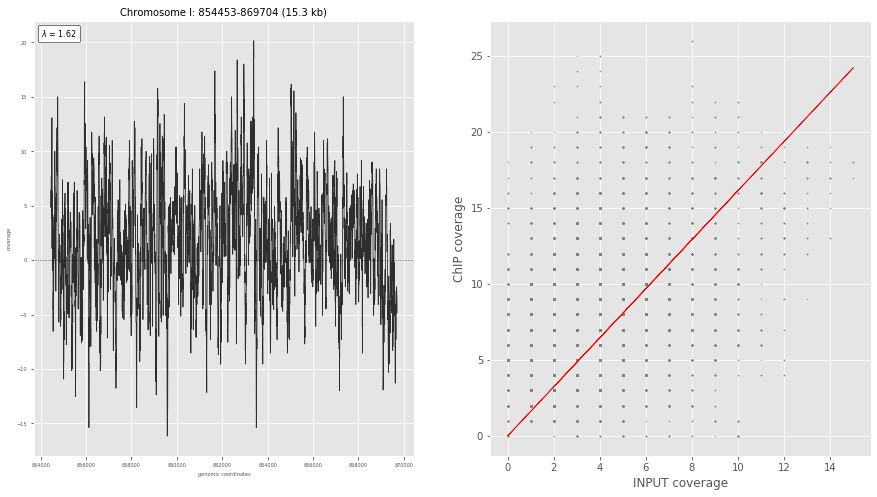

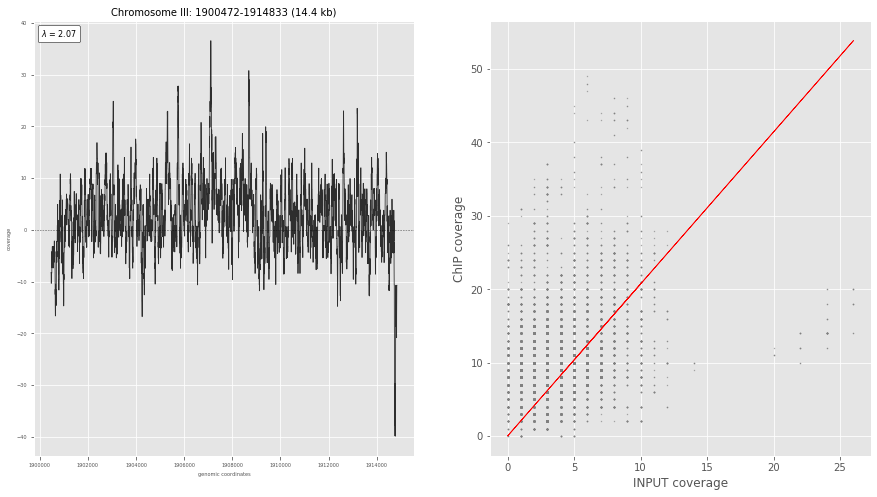

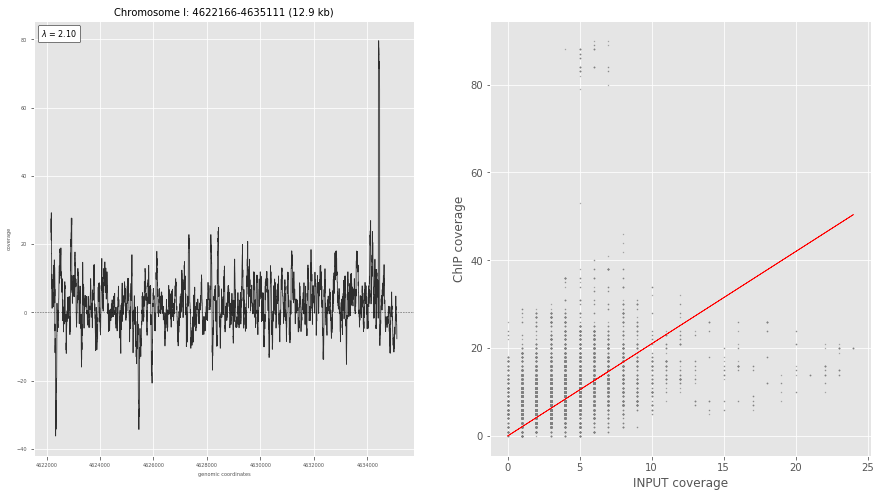

In [42]:
for ii, gg_i in enumerate(genomic_intervals):
    # only plot first regions if there are too many
    if (ii < 3):
        lregression_lambdas[gg_i["id"]], lregression_normed_cvg_profiles[gg_i["id"]] = ip.linear_regression_input_factor(gg_i, cvg_profiles, input_cvg_profiles, figsize=figsize)
    else: 
        lregression_lambdas[gg_i["id"]], lregression_normed_cvg_profiles[gg_i["id"]] = ip.linear_regression_input_factor(gg_i, cvg_profiles, input_cvg_profiles, verbose=False, plot_coverage=False)

------------

## Investigate INPUT subtraction **scaling factor**: $\lambda$

- Check **agreement** between both **approaches** and **across regions**:

In [43]:
#abs(global_lambda - a)

**Global** norm factor

In [44]:
global_lambdas
len(global_lambdas)

5120

**Local** norm factor (linear-regression)

In [45]:
lregression_lambdas
len(lregression_lambdas)

5120

**Average** norm factor

In [46]:
# Example to find the average of the list
from statistics import mean

# concatenate lists with '+' operator
mean_lambda = mean(list(lregression_lambdas.values()) + list(global_lambdas.values()) )
mean_lambda

2.429026476623572

In [47]:
print(" Scaling factor (λ) used in the analysis: {:.3f}".format(mean_lambda))

 Scaling factor (λ) used in the analysis: 2.429


- Convert results to **Data Frame**

In [48]:
combined_lambdas = {key:[lregression_lambdas[key], global_lambdas[key]] for key in lregression_lambdas}
combined_lambdas['method'] = ['linear_regression', 'global_lambda']

lambda_df = pd.DataFrame.from_dict(combined_lambdas)
#lambda_df = lambda_df.melt(id_vars='method', var_name='chrom', value_name='input_factor')
lambda_df = lambda_df.melt(id_vars='method', var_name='region_id', value_name='input_factor')

In [49]:
lambda_df.head()

,method,region_id,input_factor
0,linear_regression,SPAC23G3.02c,1.615118
1,global_lambda,SPAC23G3.02c,2.075910
2,linear_regression,SPCC737.08,2.071934
3,global_lambda,SPCC737.08,2.752100
4,linear_regression,SPAC1093.06c,2.100211


In [50]:
lambda_df.shape

(10240, 3)

- Add `ChIP` and `INPUT` **id's**:

In [51]:
lambda_df['chip_id'] = dataset_id
lambda_df['input_id'] = input_dataset_id

In [52]:
lambda_df.head()

,method,region_id,input_factor,chip_id,input_id
0,linear_regression,SPAC23G3.02c,1.615118,638_H3K9me2_1,638_S2-ChIP-INPUT_1
1,global_lambda,SPAC23G3.02c,2.075910,638_H3K9me2_1,638_S2-ChIP-INPUT_1
2,linear_regression,SPCC737.08,2.071934,638_H3K9me2_1,638_S2-ChIP-INPUT_1
3,global_lambda,SPCC737.08,2.752100,638_H3K9me2_1,638_S2-ChIP-INPUT_1
4,linear_regression,SPAC1093.06c,2.100211,638_H3K9me2_1,638_S2-ChIP-INPUT_1


In [53]:
lambda_df.shape

(10240, 5)

- Store as `.csv` file

In [54]:
#lambda_input_factors_file = os.path.join(out_dir, "INPUT_factors.csv")
#lambda_df.to_csv(lambda_input_factors_file, sep='\t', index=None)

#### **A**. Summarize results for **lambda coefficients** (across genes)

In [55]:
# 95th Percentile
def q95(x):
    return x.quantile(0.95)
# 98th Percentile
def q98(x):
    return x.quantile(0.98)

In [56]:
lambda_summary = lambda_df.groupby('method').agg(
    # Get max of the 'input_factor' column for each group
    max_if =('input_factor', max),
    # Get min of the 'input_factor' column for each group
    min_if=('input_factor', min),
    # Get mean of the 'input_factor' column for each group
    mean_if=('input_factor', mean),
    # Get median of the 'input_factor' column for each group
    median_if=('input_factor', 'median'),
    # Get standard deviation of the 'input_factor' column for each group
    std_if=('input_factor', 'std'),
    # Get 95th quantile of the 'input_factor' column for each group
    quantile_95_if=('input_factor', q95),
    # Get 98th quantile of the 'input_factor' column for each group
    quantile_98_if=('input_factor', q98),
    # Apply a lambda to date column
    #num_days=("date", lambda x: (max(x) - min(x)).days)    
)
lambda_summary

,max_if,min_if,mean_if,median_if,std_if,quantile_95_if,quantile_98_if
method,,,,,,,
global_lambda,135.505841,0.020560,2.687283,2.109132,6.882548,3.107295,3.533262
linear_regression,122.941800,0.020556,2.170770,1.694775,5.629820,2.507211,2.940069


#### **B**. Visualize distribution for **lambda coefficients** (across genes)

In [57]:
import seaborn as sns
sns.__version__

'0.11.1'

In [58]:
lambda_max = 5
#lambda_max = max(lambda_summary['quantile_98_if'])
lambda_max

5

In [59]:
#lambda_plot = lambda_df[lambda_df['input_factor'] < lambda_max]
lambda_plot = lambda_df[lambda_df['input_factor'] > lambda_max]
#lambda_plot

- Visualize lambda factor **distributions**

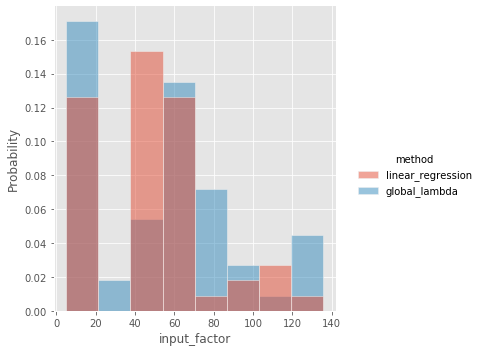

In [60]:
#sns.displot(lambda_plot, x="input_factor", hue="method", stat="density", common_norm=False)
ax = sns.displot(lambda_plot, x="input_factor", hue="method", stat="probability")

In [61]:
#sns.displot(lambda_plot, x="input_factor", col="method", multiple="dodge")

---

# Investigate counts after INPUT subtraction

---

- Get **input factor** calculated
    - **638_H3K9me2_1**: median
        - `638_S2-ChIP-INPUT_1`: **2.109**
        - `638_S2-ChIP-INPUT_2`: **0.842**
        - `638_S2-ChIP-INPUT_3`: **0.499**
    - **WT_H3K9me2_1**: median
        - `WT_S2-ChIP-INPUT_1`: **0.897**

In [194]:
#lambda_summary

In [195]:
input_factor = lambda_summary.loc['global_lambda']['median_if'].round(3)
#input_factor = lambda_summary.loc['global_lambda']['quantile_98_if'].round(3)
input_factor

2.109

- Load `TPM`/ `count` files:

In [196]:
use_counts=True
#use_counts=False

In [197]:
repeat_id = ''

### **INPUT** TPM file

In [198]:
if not use_counts:
    input_tpm_file = os.path.join(project_data_dir, "results", data_input_batch, "xp_data", input_dataset_id, input_dataset_id + "_pombe_tpm_matrix.csv")
else:
    input_tpm_file = os.path.join(project_data_dir, "results", data_input_batch, "xp_data", input_dataset_id, input_dataset_id + "_pombe_gene_count_matrix.csv")
print(input_tpm_file)

/gcm-lfs1/pablo/data/rna_silencing/results/INPUT/xp_data/638_S2-ChIP-INPUT_1/638_S2-ChIP-INPUT_1_pombe_gene_count_matrix.csv


In [199]:
input_tpm_df = pd.read_csv(input_tpm_file, sep='\t')
assert input_tpm_df['count'].isnull().values.any()
input_tpm_df.head()
#input_tpm_df[input_tpm_df['gene_id'].isin(all_htc_genes)]

,gene_id,count,gene_name,transcript_length,gene_length,type,category
0,SPBC460.01c,78.0,NaN,1719.0,1719,gene,gene
1,SPBC460.02c,90.0,NaN,663.0,948,gene,gene
2,SPBC460.03,122.0,vba2,1704.0,1704,gene,gene
3,SPBC460.04c,84.0,NaN,1176.0,1176,gene,gene
4,SPBC460.05,109.0,NaN,1593.0,1593,gene,gene


In [200]:
input_tpm_df.shape

(7018, 7)

- Check total number of `TPM`/ `count`
    - `638_S2-ChIP-INPUT_1`: 
        - All genes: **1.000.000** / **1.563.165** 
        - mRNA gens: **969.170** / **1.507.005**
        - Repeats: **9.618** / **34.081**
        - Repeats (%): **0.96%** / **2.1%**

In [201]:
input_total_counts = input_tpm_df['count'].sum()
input_total_counts

1563165.0

In [202]:
#input_tpm_df['category'].unique()
#input_tpm_df['type'].unique()
#input_tpm_df['count'][input_tpm_df['category'] == 'ribosomal'].sum() # 22.079

In [203]:
input_mrna_counts = input_tpm_df['count'][input_tpm_df['category'] == 'gene'].sum()
input_mrna_counts

1507005.0

In [204]:
#input_tpm_df[input_tpm_df['category'] == 'repeat']
#input_tpm_df[input_tpm_df['gene_id'].isin(all_htc_genes)]
# gene_1 = input_tpm_df[input_tpm_df['category'] == 'repeat']['gene_id'].tolist()
# gene_2 = input_tpm_df[input_tpm_df['gene_id'].isin(all_htc_genes)]['gene_id'].tolist()
# set(gene_2).symmetric_difference(gene_1) # `all_htc_genes` is missing `mat locus` features and the annotated 'dg_repeat' and 'dh_repeat'

In [205]:
#input_htc_counts = input_tpm_df['count'][input_tpm_df['gene_id'].isin(all_htc_genes)].sum() # `all_htc_genes` is missing `mat locus` features and the annotated 'dg_repeat' and 'dh_repeat'
input_htc_counts = input_tpm_df['count'][input_tpm_df['category'] == 'repeat'].sum()
#input_htc_counts = input_total_counts - input_mrna_counts # there are also ribosomal!
input_htc_counts

34081.0

In [206]:
input_htc_ratio = input_htc_counts / input_total_counts
input_htc_ratio

0.021802560830110704

### **ChIP** TPM file - <font color='red'> **previous to INPUT subtraction** </font> 

In [207]:
if not use_counts:
    tpm_file = os.path.join(project_data_dir, "results", data_batch, "xp_data", dataset_id, dataset_id + "_pombe_tpm_matrix.csv")
else:
    tpm_file = os.path.join(project_data_dir, "results", data_batch, "xp_data", dataset_id, dataset_id + "_pombe_gene_count_matrix.csv")
print(tpm_file)

/gcm-lfs1/pablo/data/rna_silencing/results/H3K9me2/xp_data/638_H3K9me2_1/638_H3K9me2_1_pombe_gene_count_matrix.csv


In [208]:
tpm_df = pd.read_csv(tpm_file, sep='\t')
assert tpm_df['count'].isnull().values.any()
tpm_df.head()
#tpm_df[tpm_df['gene_id'].isin(all_htc_genes)]

,gene_id,count,gene_name,transcript_length,gene_length,type,category
0,SPBC460.01c,354.0,NaN,1719.0,1719,gene,gene
1,SPBC460.02c,209.0,NaN,663.0,948,gene,gene
2,SPBC460.03,408.0,vba2,1704.0,1704,gene,gene
3,SPBC460.04c,186.0,NaN,1176.0,1176,gene,gene
4,SPBC460.05,310.0,NaN,1593.0,1593,gene,gene


In [209]:
tpm_df.shape

(7018, 7)

- Check total number of `TPM`/ `count`
    - `638_H3K9me2_1`: **wo** INPUT subtraction
        - All genes: **1.000.000** / **3.343.510** 
        - mRNA gens: **643.219** / **2.440.439**
        - Repeats: **338.539** / **871.699**
        - Repeats (%): **33.85%** / **26.1%**

In [210]:
tpm_total_counts = tpm_df['count'].sum()
tpm_total_counts

3343510.0

In [211]:
#tpm_df['category'].unique()
#tpm_df['type'].unique()
#tpm_df['count'][tpm_df['category'] == 'ribosomal'].sum() # 31.372

In [212]:
tpm_mrna_counts = tpm_df['count'][tpm_df['category'] == 'gene'].sum()
tpm_mrna_counts

2440439.0

In [213]:
#tpm_htc_counts = tpm_df['count'][tpm_df['gene_id'].isin(all_htc_genes)].sum() # `all_htc_genes` is missing `mat locus` features and the annotated 'dg_repeat' and 'dh_repeat'
tpm_htc_counts = tpm_df['count'][tpm_df['category'] == 'repeat'].sum()
#tpm_htc_counts = tpm_total_counts - tpm_mrna_counts # there are also ribosomal!
tpm_htc_counts

871699.0

In [214]:
tpm_htc_ratio = tpm_htc_counts / tpm_total_counts
tpm_htc_ratio

0.26071374094888305

### **ChIP** TPM file - <font color='red'>  **after INPUT subtraction** </font>

In [215]:
if not use_counts:
    input_subtracted_tpm_file = os.path.join(project_data_dir, "results", data_batch, "xp_data", dataset_id, dataset_id + "_subtracted_INPUT_pombe_tpm_matrix.csv")
else:
    input_subtracted_tpm_file = os.path.join(project_data_dir, "results", data_batch, "xp_data", dataset_id, dataset_id + "_subtracted_INPUT_pombe_gene_count_matrix.csv")
print(input_subtracted_tpm_file)

/gcm-lfs1/pablo/data/rna_silencing/results/H3K9me2/xp_data/638_H3K9me2_1/638_H3K9me2_1_subtracted_INPUT_pombe_gene_count_matrix.csv


In [216]:
tpm_ip_subtracted_df = pd.read_csv(input_subtracted_tpm_file, sep='\t')
assert tpm_ip_subtracted_df['count'].isnull().values.any()
tpm_ip_subtracted_df.head()
#tpm_ip_subtracted_df[tpm_ip_subtracted_df['gene_id'].isin(all_htc_genes)]

,gene_id,count,gene_name,transcript_length,gene_length,type,category
0,FP565355_region_1..2120,16750.253,NaN,2120.0,2120,region,repeat
1,FP565355_region_15417..15473,126.782,NaN,57.0,57,region,repeat
2,FP565355_region_15474..15608,2680.948,NaN,135.0,135,region,repeat
3,FP565355_region_15609..16735,13315.612,NaN,1127.0,1127,region,repeat
4,FP565355_region_16736..16794,205.891,NaN,59.0,59,region,repeat


In [217]:
tpm_ip_subtracted_df.shape

(7018, 7)

In [218]:
#tpm_ip_subtracted_df[tpm_ip_subtracted_df['gene_id'].isin(all_htc_genes)]['count']

- <font color='red'> **Attention!** 
    - After INPUT subtraction there are counts with negative values!
    - After removing negative counts we **DO NOT HAVE TPM anymore (need to re-scale)!** </font>
=> **Not anymore bug has been fixed!**

In [219]:
tpm_ip_subtracted_df[tpm_ip_subtracted_df['count'] < 0]

,gene_id,count,gene_name,transcript_length,gene_length,type,category


In [220]:
# turn negative counts to zeros
tpm_ip_subtracted_df['count'] = tpm_ip_subtracted_df['count'].clip(lower=0)
#tpm_ip_subtracted_df

In [221]:
# re-scale to add to 10^6
if not use_counts:
    
    ## Sum up all the RPK values in a sample and divide this number by 1,000,000.
    per_million = tpm_ip_subtracted_df['count'].sum() / (10 ** 6)
    #per_million

    ## Divide the RPK values by the 'per million' scaling factor.
    tpm_ip_subtracted_df['count'] = tpm_ip_subtracted_df['count'] / per_million

- Check total number of `TPM`/ `count`
    - `638_H3K9me2_1`: **with** INPUT subtraction
        - All genes: **1.000.000** <font color='red'> (**!! 371.894**) </font> / **1.201.270** <font color='red'> (**893.600**) </font> 
        - mRNA gens: **276.313**  <font color='red'> (**67.336**) </font> / **400.570** <font color='red'> (**142.288**) </font>  
        - Repeats: **722.822** <font color='red'> (**304.558**) </font> / **799.822** <font color='red'> (**751.290**) </font> 
        - Repeats (%): **72.28%** <font color='red'> (**81.89%**) </font> / **66.58%** <font color='red'> (**84.1%**) </font> 
        
<font color='red'> **In red, values computed previous to fixing bug with negative TPM normalization factor!** </font> <br>
<font color='red'> **TPM NOT ADDING TO 10^6!** </font>

In [222]:
tpm_ip_subtracted_total_counts = tpm_ip_subtracted_df['count'].sum()
tpm_ip_subtracted_total_counts

1201270.011

In [223]:
#tpm_ip_subtracted_df['category'].unique()
#tpm_ip_subtracted_df['type'].unique()
#tpm_ip_subtracted_df['count'][tpm_ip_subtracted_df['category'] == 'ribosomal'].sum() # 20

In [224]:
tpm_ip_subtracted_mrna_counts = tpm_ip_subtracted_df['count'][tpm_ip_subtracted_df['category'] == 'gene'].sum()
tpm_ip_subtracted_mrna_counts

400570.721

In [225]:
#tpm_ip_subtracted_htc_counts = tpm_ip_subtracted_df['count'][tpm_ip_subtracted_df['gene_id'].isin(all_htc_genes)].sum() # `all_htc_genes` is missing `mat locus` features and the annotated 'dg_repeat' and 'dh_repeat'
tpm_ip_subtracted_htc_counts = tpm_ip_subtracted_df['count'][tpm_ip_subtracted_df['category'] == 'repeat'].sum()
#tpm_ip_subtracted_htc_counts = tpm_ip_subtracted_total_counts - tpm_ip_subtracted_mrna_counts
tpm_ip_subtracted_htc_counts

799822.1709999997

In [226]:
tpm_ip_subtracted_htc_ratio = tpm_ip_subtracted_htc_counts / tpm_ip_subtracted_total_counts
tpm_ip_subtracted_htc_ratio

0.665813816773954

---

- Recompute `INPUT` **subtraction** from files:

In [227]:
# new_tpm_ip_subtracted_df = tpm_df.merge(
#     input_tpm_df[['gene_id', 'count']],
#     how = 'inner',
#     on='gene_id',
#     suffixes=['_chip', '_ip']
# )

In [228]:
df_list = [ df.set_index(['gene_id']) for df in [
    tpm_df.rename(columns={"count": "count_chip"}), 
    input_tpm_df[['gene_id', 'count']].rename(columns={"count": "count_ip"}), 
    tpm_ip_subtracted_df[['gene_id', 'count']].rename(columns={"count": "count_ip_subtracted"}) 
]]

new_tpm_ip_subtracted_df = pd.concat(
    df_list ,
    join='inner',
    axis=1
).reset_index()

In [229]:
new_tpm_ip_subtracted_df.head()

,gene_id,count_chip,gene_name,transcript_length,gene_length,type,category,count_ip,count_ip_subtracted
0,SPBC460.01c,354.0,NaN,1719.0,1719,gene,gene,78.0,189.498
1,SPBC460.02c,209.0,NaN,663.0,948,gene,gene,90.0,19.190
2,SPBC460.03,408.0,vba2,1704.0,1704,gene,gene,122.0,150.702
3,SPBC460.04c,186.0,NaN,1176.0,1176,gene,gene,84.0,8.844
4,SPBC460.05,310.0,NaN,1593.0,1593,gene,gene,109.0,80.119


In [230]:
new_tpm_ip_subtracted_df.shape

(7018, 9)

Compute **new subtraction** - merge DataFames

In [231]:
new_tpm_ip_subtracted_df['count_new_ip_subtracted'] = new_tpm_ip_subtracted_df['count_chip'] - input_factor * new_tpm_ip_subtracted_df['count_ip'].fillna(0)
new_tpm_ip_subtracted_df.head()

,gene_id,count_chip,gene_name,transcript_length,gene_length,type,category,count_ip,count_ip_subtracted,count_new_ip_subtracted
0,SPBC460.01c,354.0,NaN,1719.0,1719,gene,gene,78.0,189.498,189.498
1,SPBC460.02c,209.0,NaN,663.0,948,gene,gene,90.0,19.190,19.190
2,SPBC460.03,408.0,vba2,1704.0,1704,gene,gene,122.0,150.702,150.702
3,SPBC460.04c,186.0,NaN,1176.0,1176,gene,gene,84.0,8.844,8.844
4,SPBC460.05,310.0,NaN,1593.0,1593,gene,gene,109.0,80.119,80.119


In [232]:
new_tpm_ip_subtracted_df.shape

(7018, 10)

- <font color='red'> **Attention!** 
    - After INPUT subtraction there are counts with negative values! Turn these into zeros!

In [233]:
#new_tpm_ip_subtracted_df[new_tpm_ip_subtracted_df['count_new_ip_subtracted'] < 0]

In [234]:
# turn negative counts to zeros
new_tpm_ip_subtracted_df['count_new_ip_subtracted'] = new_tpm_ip_subtracted_df['count_new_ip_subtracted'].clip(lower=0)
#new_tpm_ip_subtracted_df

Compute **TPM** expression

In [235]:
from gene_counts import get_tpm_gene_counts

In [236]:
#new_tpm_ip_subtracted_df['tpm_new_ip_subtracted']
new_tpm_ip_subtracted_df = new_tpm_ip_subtracted_df.merge(
    get_tpm_gene_counts(
        new_tpm_ip_subtracted_df,
        count_col='count_new_ip_subtracted', 
        length_col='gene_length', 
        read_length = 50
    ).rename(columns={"count_new_ip_subtracted": "tpm_new_ip_subtracted"})[['gene_id', 'tpm_new_ip_subtracted']],
    how = 'inner',
    on='gene_id'
)


Calculated TPM for 7018 genes.
Used `length_col`: gene_length for normalization.


In [237]:
new_tpm_ip_subtracted_df[new_tpm_ip_subtracted_df['gene_id'].isin(all_htc_genes)]

,gene_id,count_chip,gene_name,transcript_length,gene_length,type,category,count_ip,count_ip_subtracted,count_new_ip_subtracted,tpm_new_ip_subtracted
5,SPAC212.11,90836.0,tlh1,5662.0,5662,gene,repeat,1436.0,87807.476,87807.476,17119.716047
6,SPAC212.11b,90836.0,tlh1_plus,5662.0,5662,gene,repeat,1436.0,87807.476,87807.476,17119.716047
7,SPAC212.10b,11071.0,SPAC212.10_plus,606.0,606,gene,repeat,130.0,10796.830,10796.830,21212.955150
8,SPAC212.10,11071.0,NaN,606.0,606,gene,repeat,130.0,10796.830,10796.830,21212.955150
9,SPAC212.09c,29027.0,NaN,1656.0,1656,gene,repeat,381.0,28223.471,28223.471,19220.056159
10,SPNCRNA.70,13006.0,NaN,530.0,530,gene,repeat,134.0,12723.394,12723.394,28947.962759
11,SPAC212.08c,28171.0,NaN,1211.0,1211,gene,repeat,244.0,27656.404,27656.404,26046.518894
12,SPAC212.07c,4168.0,NaN,891.0,891,gene,repeat,81.0,3997.171,3997.171,5195.181706
14,SPAC212.12,11622.0,NaN,372.0,372,gene,repeat,88.0,11436.408,11436.408,38747.815570
15,SPAC212.06c,23320.0,NaN,891.0,933,gene,repeat,213.0,22870.783,22870.783,28313.194598


- Try to infer `INPUT` **subtraction factor** used in analysis

Does not make sense. Did I use a different INPUT to compute subtraction?

In [238]:
new_tpm_ip_subtracted_df['infered_factor'] = (new_tpm_ip_subtracted_df['count_chip'] - new_tpm_ip_subtracted_df['count_ip_subtracted']) /  new_tpm_ip_subtracted_df['count_ip']
#new_tpm_ip_subtracted_df['infered_factor'] = (new_tpm_ip_subtracted_df['count_chip'] - new_tpm_ip_subtracted_df['count_new_ip_subtracted']) /  new_tpm_ip_subtracted_df['count_ip']
new_tpm_ip_subtracted_df

,gene_id,count_chip,gene_name,transcript_length,gene_length,type,category,count_ip,count_ip_subtracted,count_new_ip_subtracted,tpm_new_ip_subtracted,infered_factor
0,SPBC460.01c,354.0,NaN,1719.0,1719,gene,gene,78.0,189.498,189.498,124.179031,2.109
1,SPBC460.02c,209.0,NaN,663.0,948,gene,gene,90.0,19.190,19.190,23.360137,2.109
2,SPBC460.03,408.0,vba2,1704.0,1704,gene,gene,122.0,150.702,150.702,99.650877,2.109
3,SPBC460.04c,186.0,NaN,1176.0,1176,gene,gene,84.0,8.844,8.844,8.587859,2.109
4,SPBC460.05,310.0,NaN,1593.0,1593,gene,gene,109.0,80.119,80.119,56.786922,2.109
...,...,...,...,...,...,...,...,...,...,...,...,...
7013,SPRRNA.51,NaN,NaN,165.0,165,gene,gene,NaN,NaN,NaN,NaN,NaN
7014,SPRRNA.52,NaN,NaN,165.0,165,gene,gene,NaN,NaN,NaN,NaN,NaN
7015,SPRRNA.55,NaN,NaN,115.0,115,gene,gene,NaN,NaN,NaN,NaN,NaN
7016,SPSNORNA.18,NaN,snoU24,47.0,47,gene,gene,NaN,NaN,NaN,NaN,NaN


In [242]:
input_factor

2.109

In [243]:
#new_tpm_ip_subtracted_df[new_tpm_ip_subtracted_df['infered_factor'] != input_factor]

In [259]:
new_tpm_ip_subtracted_df[new_tpm_ip_subtracted_df['infered_factor'] > 10]

,gene_id,count_chip,gene_name,transcript_length,gene_length,type,category,count_ip,count_ip_subtracted,count_new_ip_subtracted,tpm_new_ip_subtracted,infered_factor


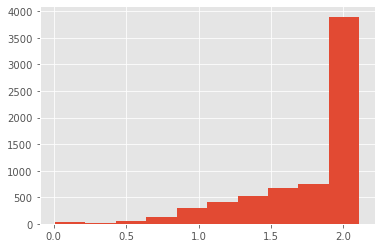

In [240]:
new_tpm_ip_subtracted_df['infered_factor'].hist()